In [7]:
from readRinexObs import rinexobs
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from pandas import DataFrame, Panel

In [8]:
data = rinexobs("mah22800.15o")

mah22800.15o is a RINEX 2.11 file.
15.89 seconds for _block2df
7.79 seconds for panel assignments
finished in 25.66 seconds


This script filters the data from the rinex file to look at only the first tlim points, which in this case turns out to be from about 6-7 UTC. It then further filters the points to only include satellites with a minimum of minpoints L1, L2, C1, and C2 values that aren't Nan. Finally only points with TEC values between 0 and 200 (in TECu, I believe) are included in the final dataframe, interesting_data. TEC is calculated according to the method in Bill Rideout's program, tec.py. NOTE: in his program, he only plots short blocks of data, about 30 seconds in length according to him, at a time, where there are no large (>1 TECu) jumps in TEC. I included all the data from 6-7 UTC and it is pretty messy. 

In [2]:
fig = plt.figure(figsize=(14,14))
tlim = 4000
minpoints = 3000

svs_with_pts_in_range = [i for i in data.items if(np.sum(np.logical_and.reduce(
                (data[data.labels[:tlim],i,'L1','data']>0,
                 data[data.labels[:tlim],i,'L2','data']>0,
                 data[data.labels[:tlim],i,'C1','data']>0,
                 data[data.labels[:tlim],i,'C2','data']>0)))>minpoints)]

#Bill's Calculation:
convertL1ToMeters = 3.0E8/(154.0*10.23E6)
convertL2ToMeters = 3.0E8/(120.0*10.23E6)
f2f1Factor = 1.545727
convertMetersToTEC = 6.158

interesting_data = DataFrame()

for sv in svs_with_pts_in_range:
    diffrange = data[data.labels[:tlim],sv,'C2','data']-data[data.labels[:tlim],sv,'C1','data']
    diffrange = diffrange*convertMetersToTEC*f2f1Factor
    phase = f2f1Factor*(convertL1ToMeters*data[data.labels[:tlim],sv,'L1','data']
                        -convertL2ToMeters*data[data.labels[:tlim],sv,'L2','data'])

    phase = phase*convertMetersToTEC
    median = sorted(list(phase-diffrange))[int(len(diffrange)/2)]
    TEC = phase-median
    interesting_data[sv]=TEC[np.logical_and(TEC<200,TEC>0)]

    print("SVN: {}, Pts above 200: {}, Pts below zero: {}, NaNs: {}".format(sv,
                                                                            np.sum(TEC>200),
                                                                            np.sum(TEC<0),
                                                                            np.sum(np.isnan(TEC))))
    
    
fig = plt.figure(figsize=(16,16))
ax1 = plt.subplot(211)
fmt = DateFormatter('%H:%M:%S')
ax1.xaxis.set_major_formatter(fmt)
ax1.autoscale_view()
plt.xlabel('Time')
plt.ylabel('TECu')
plt.title("Rideout's TEC Method")

lines = plt.plot(interesting_data)
plt.legend(lines,interesting_data.columns)
plt.grid()

plt.show()

NameError: name 'plt' is not defined

Below I explored the loss of lock indicator. If the 0 bit is set in the lli (loss of lock indicator), that means that the receiver thinks it lost lock on the previous measurement. I made a mask of all the points where lock was lost across all four relevant parameters (L1,L2,C1,P2 in this case), and plotted those as red x's on top of the TEC plot. Underneath is the SNR (S1 and S2). As you can see, in this case, the lli looks pretty good but the SNR doesn't appear to show anything. Underneath all that is the signal strength indicator which maps the signal strength a value from 0 to 9. In this case it doesn't appear to show anything either.

### SVN = 23

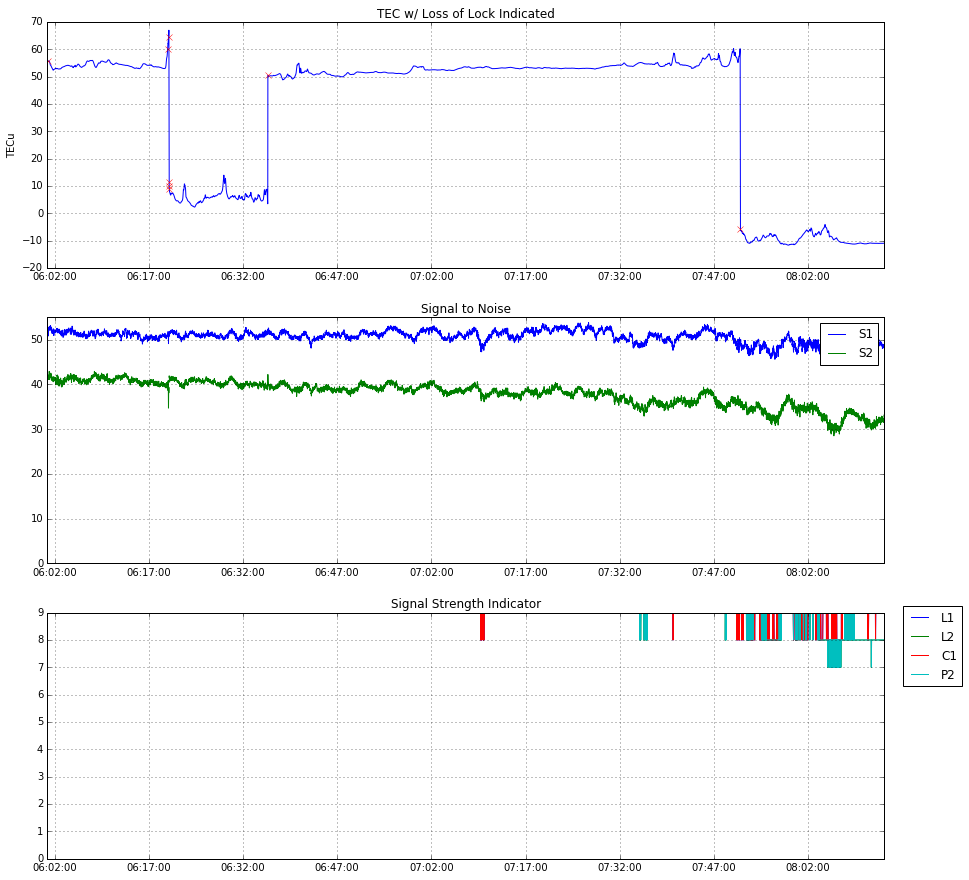

In [10]:
svn = 23
tlim2 = 8000

lli = data[data.labels[:tlim2],svn,['L1','L2','C1','P2'],'lli']
lli[np.isnan(lli)]=0
lli=lli.astype(int)
llimask = np.logical_or.reduce(lli%2)


fig2 = plt.figure(figsize=(15,15))
ax1 = plt.subplot(311)
ax1.xaxis.set_major_formatter(fmt)
plt.ylabel('TECu')
plt.title('TEC w/ Loss of Lock Indicated')
plt.grid()

diffrange = data[data.labels[:tlim2],svn,'P2','data']-data[data.labels[:tlim2],svn,'C1','data']
diffrange = diffrange*convertMetersToTEC*f2f1Factor
phase = f2f1Factor*(convertL1ToMeters*data[data.labels[:tlim2],svn,'L1','data']
                    -convertL2ToMeters*data[data.labels[:tlim2],svn,'L2','data'])

phase = phase*convertMetersToTEC
median = sorted(list(phase-diffrange))[int(len(diffrange)/2)]
TEC = phase-median

plt.plot(TEC[TEC<200])
plt.plot(TEC[llimask][TEC[llimask]<200],'rx')

ax2 = plt.subplot(312, sharex=ax1)
plt.plot(data[data.labels,svn,'S1','data'][:tlim2])
plt.plot(data[data.labels,svn,'S2','data'][:tlim2])
plt.grid()
plt.legend(['S1','S2'])
plt.title('Signal to Noise')
plt.yticks(np.arange(0,60,10))

ax3 = plt.subplot(313, sharex=ax1)
[plt.plot(data[data.labels[:tlim2],svn,a,'ssi']) for a in ['L1','L2','C1','P2']]
plt.legend(['L1','L2','C1','P2'],bbox_to_anchor=(1.1, 1.05))
plt.yticks(np.arange(10))
plt.grid()
plt.title("Signal Strength Indicator")

plt.show()


In [15]:
from datetime import datetime
start = datetime(year=2015,month=10,day=7,hour=6,minute=0,second=49)
end = datetime(year=2015,month=10,day=7,hour=7,minute=7,second=30)
data[end]

<class 'pandas.core.panel.Panel'>
Dimensions: 21 (items) x 10 (major_axis) x 3 (minor_axis)
Items axis: 2 to 32
Major_axis axis: C1 to S5
Minor_axis axis: data to ssi